# Определение перспективного тарифа для телеком компании


**Цель**: Определить выгодный тарифный план для корректировки рекламного бюджета.

**Выборка**. Данные 500 пользователей тарифных планов «Смарт» и «Ультра»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Описание тарифов**
   
   * **Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
      - минута разговора: 3 рубля
      - сообщение: 3 рубля
      - 1 Гб интернет-трафика: 200 рублей
   
   
   * **Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
      - минута разговора: 1 рубль
      - сообщение: 1 рубль
      - 1 Гб интернет-трафика: 150 рублей

**Примечание**: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт:

* Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. 
* Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats as st

In [2]:
# код для отображения 200 столбцов в датасетах
pd.options.display.max_columns = 200

In [3]:
# прочтем датасеты
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=[0])
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
# просмотрим информацию о данных
for element in (calls, internet, messages, tariffs, users):
    element.info()
    print()
   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count 

In [5]:
# выведем первые 5 строк
calls.head() 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


С данными особо никаких проблем на первом этапе не очень заметно. Точно необходимо будет поработать с типом данным, объедением таблиц и некоторыми пропусками после объедения, так как рзмеры таблиц разныею В датасетах пропусков нетб кроме даты прекращения пользования тарифом. Пропуски в данном столбце объяснимы тем, что  что тариф еще действует на данный момент. 

Так же из документации нам известно описание данных: 

* **Описание данных**

**Таблица users (информация о пользователях):**
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

**Таблица calls (информация о звонках):**
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Предобработка данных


### Предобработка каждой таблицы(изменение типов данных, добавление столбцов, проверка на аномалии)

**Звонки**

In [10]:
# Перевод даты из объектного типа в тип datetime64
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [11]:
# Добавляем столбец с категорией месяца: Январь - 1, Февраль - 2, ..., Декабрь - 12
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [12]:
# Округляем длительность звонков к большому числу и меняем тип данных на целочисленный
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [13]:
# выведем первые 5 строк 
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [14]:
# проверим есть ли здесь аномалии в длительности звонка
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

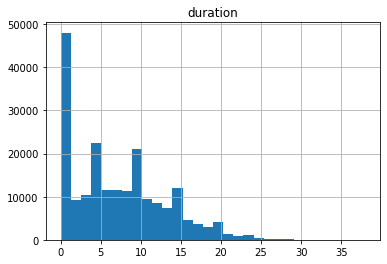

In [15]:
# построим гистограмму по столбцам для наглядности
calls.hist('duration', bins=30)

**Интернет**

In [16]:
# Перевод даты из объектного типа в тип datetime64
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [17]:
# Добавляем столбец с категорией месяца: Январь - 1, Февраль - 2, ..., Декабрь - 12
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [18]:
#выведем первые 5 строк 
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [19]:
# проверим есть ли здесь аномалии 
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

array([[<AxesSubplot:title={'center':'mb_used'}>]], dtype=object)

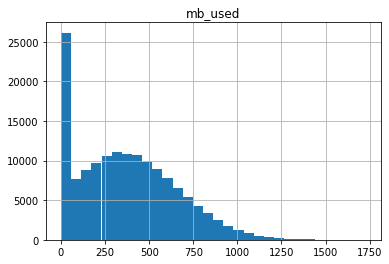

In [20]:
# строим гистограмму
internet.hist('mb_used', bins=30)

In [21]:
internet[internet['mb_used'] == 0]

,id,mb_used,session_date,user_id,month
11,1000_11,0.0,2018-08-28,1000,8
38,1000_38,0.0,2018-11-27,1000,11
46,1000_46,0.0,2018-06-30,1000,6
67,1000_67,0.0,2018-06-16,1000,6
72,1000_72,0.0,2018-06-15,1000,6
...,...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499,12
149381,1499_142,0.0,2018-11-01,1499,11
149383,1499_144,0.0,2018-11-27,1499,11
149386,1499_147,0.0,2018-10-21,1499,10


**Сообщения**

In [22]:
# Перевод даты из объектного типа в тип datetime64
messages['message_date'] = pd.to_datetime(messages['message_date'] , format='%Y-%m-%d')

# Добавляем столбец с категорией месяца: Январь - 1, Февраль - 2, ..., Декабрь - 12
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [23]:
# выведем таблицу для проверки
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [24]:
# сформируем таблицу что бы посчитать кол-во сообщений по пользователям и месяцам
messages_count = messages.groupby(['user_id','month']).agg(
    messages_used = ('id', 'count')
).reset_index()

In [25]:
messages_count

,user_id,month,messages_used
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [26]:
# посмотрим на описание таблицы
messages_count['messages_used'].describe()

count    2717.000000
mean       45.283769
std        35.051363
min         1.000000
25%        19.000000
50%        38.000000
75%        63.000000
max       224.000000
Name: messages_used, dtype: float64

array([[<AxesSubplot:title={'center':'messages_used'}>]], dtype=object)

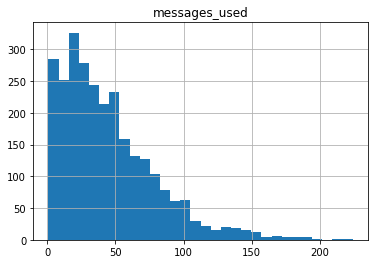

In [27]:
# построим гистограмму
messages_count.hist('messages_used', bins=30)

**Пользователи**

In [28]:
# Перевод даты из объектного типа в тип datetime64
users['churn_date'] = pd.to_datetime(users['churn_date'] , format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'] , format='%Y-%m-%d')
# Добавляем столбец с категорией месяца: Январь - 1, Февраль - 2, ..., Декабрь - 12
users['month'] = pd.DatetimeIndex(users['reg_date']).month

In [29]:
# кпроверим таблицу
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


In [30]:
# выведем описание
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [31]:
# посмотрим уникальные значения в столбце с тарифами
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [32]:
# посмотрим уникальные значения в столбце с городами
users.sort_values('city')['city'].unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [33]:
# проверим на на наличие дубликатов
users.duplicated().sum()

0

На данном этапе мы просмотрели каждую таблицу в отдельности, изменили тип данных. Добавили столбцы с месяцами для удобства расчетов, округлили данные согласно условиям оператора, проверили на дубликаты явные и неявные. 
Из явных выбивающихся значений это звонки продолжительностью 0, что объяснимо тем, что здесь просто зафискированы входящие звонки.

Так же зафиксировано почти 20 000 сессий в интернете из 150 000 с нулевыми значениями, так как в таблице взаимосвязи ни с чем не обнаружено, это совсем у разных пользователей и в разные даты, то скорей всего это входящие уведомления или человек зашел и сразу вышел. Так же, есть пропуски в датах прекращения пользования тарифом, эти пропуски объяснимы тем, что тариф еще действует, поэтому их убирать не надо.

### Расчет аггрегированных данных 

In [34]:
# посчитаем и добавим в таблицу количество и продолжительность звонков по каждому пользователю и месяцу
calls = calls.groupby(['user_id','month']).agg(
        calls_duration = pd.NamedAgg(column = 'duration', aggfunc = 'sum'),
        calls_number = ( 'id', 'count'),
    ).reset_index()
calls.sample(10)

,user_id,month,calls_duration,calls_number
2832,1446,11,642,84
2064,1330,6,760,96
348,1055,8,380,55
112,1015,8,394,54
1797,1287,12,576,72
1938,1310,3,106,15
2979,1468,8,406,49
352,1055,12,597,83
682,1110,5,366,50
1884,1300,11,658,88


In [35]:
# посчитаем и добавим в таблицу количество сообщений по каждому пользователю и месяцу
messages = messages.groupby(['user_id','month']).agg(
        msgs_number = pd.NamedAgg(column = 'id', aggfunc = 'count'),
    ).reset_index()
messages

,user_id,month,msgs_number
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [36]:
# посчитаем и добавим в таблицу количество используемых мегабайт по каждому пользователю в месяц
internet = internet.groupby(['user_id','month']).agg(
        traffic = pd.NamedAgg(column = 'mb_used', aggfunc = 'sum'),
    ).reset_index()


In [37]:
# переводим количество мегабайт в гигабайты и округляем в большую сторону, согласно условиям оператора 
internet['traffic'] = np.ceil((internet['traffic']/1024)).astype('int')
internet

,user_id,month,traffic
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
...,...,...,...
3198,1498,10,21
3199,1499,9,2
3200,1499,10,18
3201,1499,11,18


На данном этапе мы расчитали и добавили в таблицы: 
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам.

### Объедение таблиц и взгляд на общую таблицу.

In [38]:
# объеденим все таблицы в одну и выведем на экран
data = calls.merge(
    messages, how='outer', on=['user_id', 'month'])
data = data.merge(
    internet, how='outer', on=['user_id', 'month'])
data = data.merge(
    users, how='outer', on=['user_id'])
data

,user_id,month_x,calls_duration,calls_number,msgs_number,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,month_y
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3212,1489,11.0,NaN,NaN,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3213,1489,12.0,NaN,NaN,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12


In [39]:
# информация об общей таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   month_x         3214 non-null   float64       
 2   calls_duration  3174 non-null   float64       
 3   calls_number    3174 non-null   float64       
 4   msgs_number     2717 non-null   float64       
 5   traffic         3203 non-null   float64       
 6   age             3216 non-null   int64         
 7   churn_date      189 non-null    datetime64[ns]
 8   city            3216 non-null   object        
 9   first_name      3216 non-null   object        
 10  last_name       3216 non-null   object        
 11  reg_date        3216 non-null   datetime64[ns]
 12  tariff          3216 non-null   object        
 13  month_y         3216 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(3), object(4)
me

После объеденения таблиц, у нас появилось много пропусков, скорей всего это из-за того что пользователь в какой-то месяц не пользовался интернетом, не отправлял сообщения или не звонил. Поэтому логично заменить эти пропуски нулями.

In [40]:
# заменяем пропуски на нули
for element in ['calls_duration', 'calls_number', 'msgs_number', 'traffic']:
    data[element] = data[element].fillna(0)
data

,user_id,month_x,calls_duration,calls_number,msgs_number,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,month_y
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3212,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3213,1489,12.0,0.0,0.0,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3214,1128,NaN,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12


In [41]:
# проверим удалось ли избавиться от пропусков
data.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   month_x         3214 non-null   float64       
 2   calls_duration  3216 non-null   float64       
 3   calls_number    3216 non-null   float64       
 4   msgs_number     3216 non-null   float64       
 5   traffic         3216 non-null   float64       
 6   age             3216 non-null   int64         
 7   churn_date      189 non-null    datetime64[ns]
 8   city            3216 non-null   object        
 9   first_name      3216 non-null   object        
 10  last_name       3216 non-null   object        
 11  reg_date        3216 non-null   datetime64[ns]
 12  tariff          3216 non-null   object        
 13  month_y         3216 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(3), object(4)
me

Объеденили таблицы и избавились от пропусков появившихся после объеденения

### Расчет помесячной выручки по каждому пользователю

In [42]:
# переименуем название столбца в тарифах
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [43]:
# объеденим таблицу с условиями тарифов
data_with_tariff = data.merge(
    tariffs, how='outer', on=['tariff'])
data_with_tariff

,user_id,month_x,calls_duration,calls_number,msgs_number,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,0.0,0.0,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3
3212,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3
3213,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3
3214,1489,12.0,0.0,0.0,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3


In [44]:
# функция по расчету прибыли от каждого пользователя по месяцам и выведем таблицу
def calculate(row):
    pay=row['rub_monthly_fee']
    if row['calls_duration']>row['minutes_included']:
        pay+=(row['calls_duration']-row['minutes_included'])*row['rub_per_minute']
    if row['msgs_number']>row['messages_included']:
        pay+=(row['msgs_number']-row['messages_included'])*row['rub_per_message']
    if row['traffic']>row['mb_per_month_included']/1024:
        pay+=(row['traffic']-row['mb_per_month_included']/1024)*row['rub_per_gb']
    return round(pay)
 

data_with_tariff['revenue_per_month'] = data_with_tariff.apply(calculate, axis=1)
data_with_tariff   

,user_id,month_x,calls_duration,calls_number,msgs_number,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_per_month
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,1950
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,1950
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,1950
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,1950
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,0.0,0.0,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3,950
3212,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3,1550
3213,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3,1150
3214,1489,12.0,0.0,0.0,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,50,15360,500,550,200,3,3,950


### Вывод

На этапе предообработке данных мы проверили данные на аномалии, пропуски и дубликаты. Поработали с типом данных. 

Для удобства и эффективного анализа расчитали и добавили в таблицы: 
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам. 


А так же объеденили таблицу и расчитали по каждому пользователю помесячную выручку. 

## Анализ данных

In [45]:
# фунция для исследования поведения пользователейб которая: 
# расчитывает и выводит среднее, количество значений, квартили, стандартное отклонение и дисперсию 
# ящик с усами 
# строит столбчатую диаграмму по тарифам смарт и ультра
def hist_maker_and_table(df, column):
    fig = plt.figure(figsize = (21,6))
    df[df['tariff'] == 'smart'].boxplot(column, ax = plt.subplot(1,2,1))
    df[df['tariff'] == 'ultra'].boxplot(column, ax = plt.subplot(1,2,2));
    cd = df.groupby(df.tariff)[column]
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    smart = df.query('tariff == "smart"')[column]
    ultra = df.query('tariff == "ultra"')[column]
    plt.figure(figsize=(10,6))
    plt.hist(smart, bins=50, color='blue', alpha=0.5, label = 'smart', edgecolor='grey')
    plt.hist(ultra, bins=50, color='red',alpha=0.5,label = 'ultra', edgecolor='grey')

<div class="alert alert-success">
<b class="alert-heading"> Комментарий ревьюера: ОК</b>

Хорошая автоматизация.

</div>

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,417.747534,190.476754,0.0,13.58,282.0,421.5,545.00,872.71,1435.0,36281.393836
ultra,986.0,526.089249,317.887549,0.0,0.00,282.5,518.0,751.75,1291.05,1673.0,101052.493549


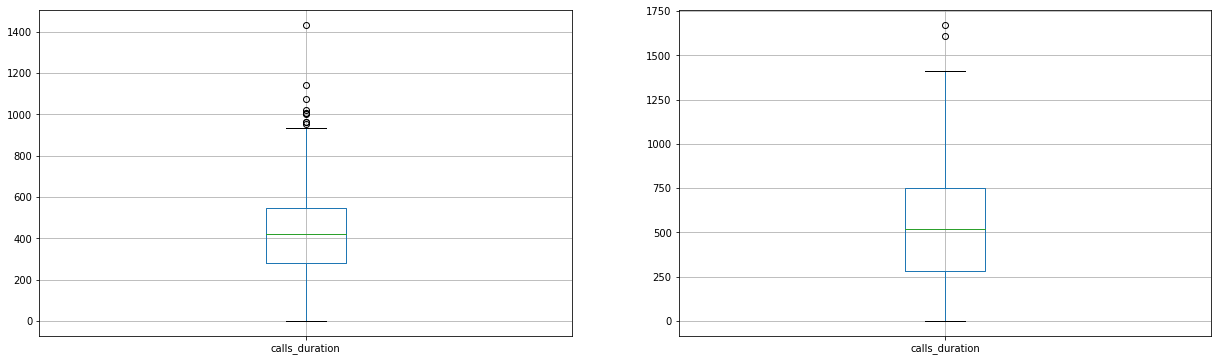

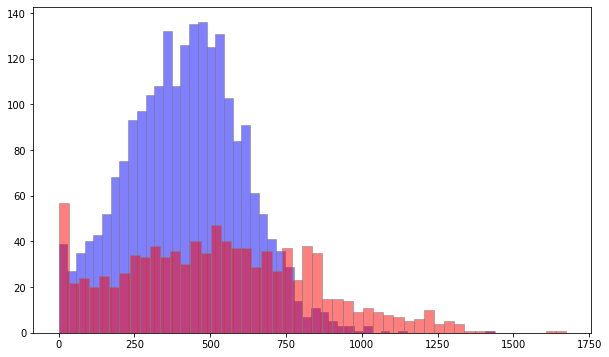

In [46]:
# посмотрим поведение пользователей по продолжительности звонков
hist_maker_and_table(data_with_tariff, 'calls_duration')

- Пользователи тарифа Смарт в среднем в месяц тратят меньше минут разговора, чем пользователи тарифа Ультра.
- На тарифе Смарт пользователи часто не укладываются в лимиты и доплачивают за звонки.
- Дисперсия и стандартное отклонение выше на тарифе Ультра, но пользователи этого тарифа всегда укладываются в установленные лимиты. 
- Максимальное число минут разговора в месяц значительно меньше заложенных в него 3000.

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,33.369058,28.230396,0.0,0.0,10.0,28.0,51.00,108.0,143.0,796.955256
ultra,986.0,49.313387,47.806040,0.0,0.0,6.0,38.0,78.75,183.3,224.0,2285.417425


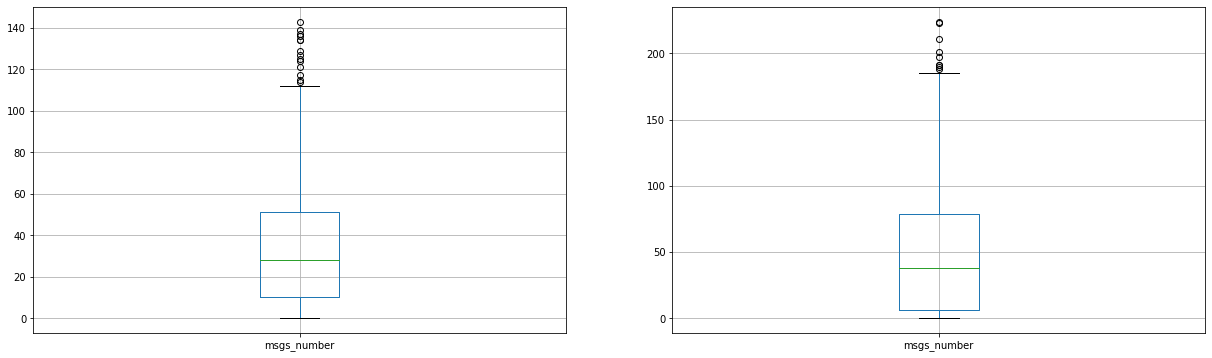

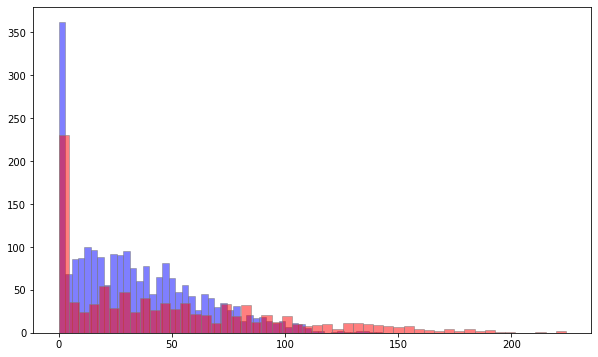

In [47]:
# посмотрим поведение пользователей по количеству сообщений
hist_maker_and_table(data_with_tariff, 'msgs_number')

- Пользователи тарифа Смарт в среднем в месяц меньше отправляют сообщений, чем пользователи тарифа Ультра.
- На тарифе Смарт примерно 25% не укладываются в лимит 50 сообщений.
- Дисперсия и стандартное отклонение выше на тарифе Ультра, но пользователи этого тарифа всегда укладываются в установленные лимиты. 
- Максимальное число сообщений в месяц значительно меньше заложенных в него 1000.

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,16.321525,5.756167,0.0,2.0,13.0,17.0,20.0,29.71,38.0,33.133453
ultra,986.0,19.474645,9.868057,0.0,0.0,12.0,19.0,27.0,42.15,49.0,97.378544


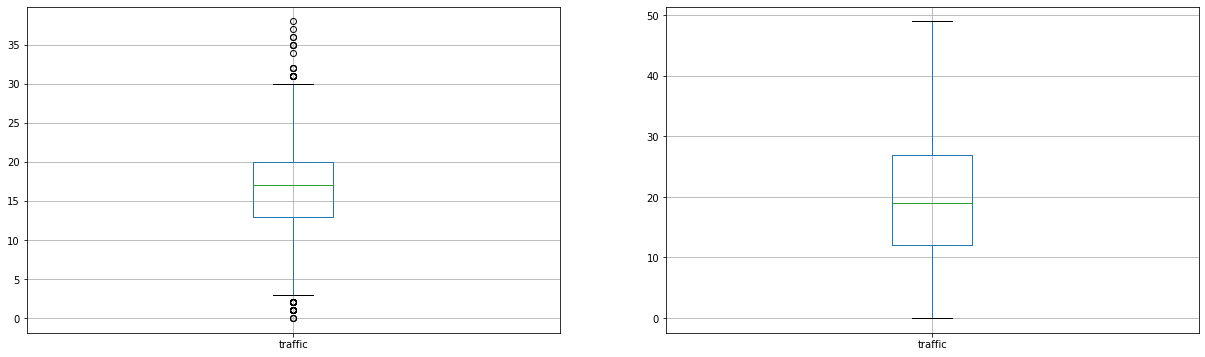

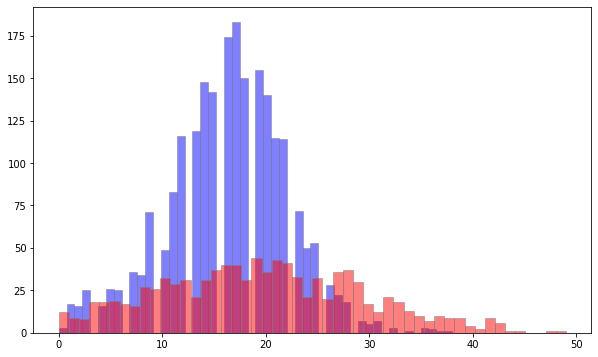

In [48]:
# посмотрим поведение пользователей по количеству использованного траффика
hist_maker_and_table(data_with_tariff, 'traffic')

- Пользователи тарифа Смарт в среднем в месяц меньше используют трафика, чем пользователи тарифа Ультра.
- На тарифе Смарт более 50% не укладываются в лимит 15 Гб.
- Дисперсия и стандартное отклонение выше на тарифе Ультра, но пользователи этого тарифа чаще укладываются в установленные лимиты. 

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,1289.641704,818.370799,550.0,550.0,550.0,1021.0,1750.0,3773.71,6770.0,669730.763895
ultra,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.0,1950.0,3772.50,4800.0,141387.714809


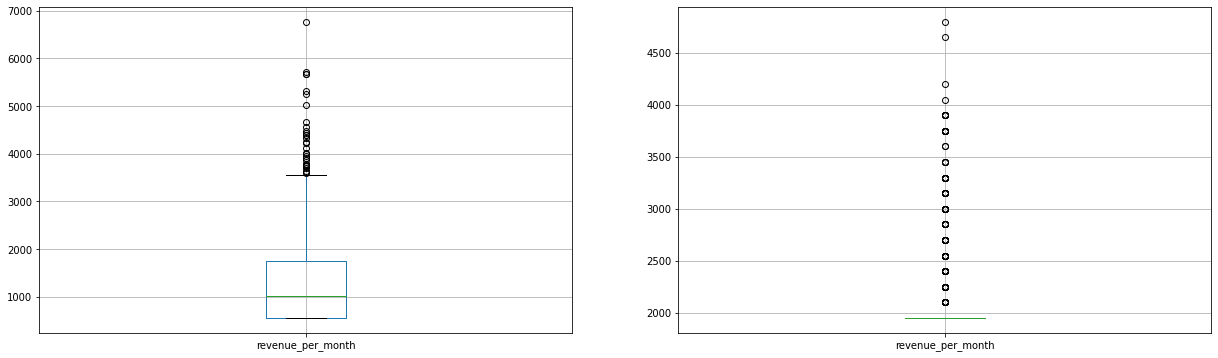

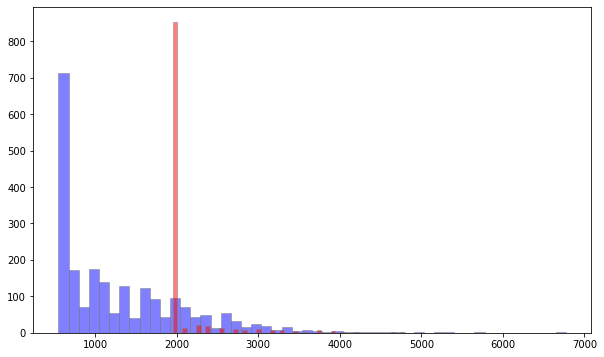

In [49]:
# посмотрим поведение пользователей как влияет на прибыль
hist_maker_and_table(data_with_tariff, 'revenue_per_month')

In [50]:
data_with_tariff.pivot_table(index='tariff', values='revenue_per_month', aggfunc=['sum', 'count', 'mean', 'median'])

,sum,count,mean,median
,revenue_per_month,revenue_per_month,revenue_per_month,revenue_per_month
tariff,,,,
smart,2875901,2230,1289.641704,1021
ultra,2041050,986,2070.030426,1950


- Пользователей тарифа Смарт примерно в 2 раза больше 
- На тарифе Смарт большинство пользователей платят больше, чем абонентская плата
- Но в среднем больше денег приносят пользователи тарифа Ультра
- В сумме больше денег принесли пользователи тарифа Смарт
- Дисперсия и стандартное отклонение выше на тарифе Смарт. 

### Вывод

По анализу наглядно видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику, и при этом большинство пользователей "Смарт" чаще не укладываются в лимит и переплачивают сверх абонентской платы. Когда как пользователи тарифа Ультра, напротив, не используют тарифный пакет в полном объеме.  
По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 2070 рублей и 1290 рублей соответственно. 
Но при этом суммарно доход больше от пользователей тарифа Smart за счет количества пользователей и плат сверх абонентской платы.


## Проверка гипотезы 

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**, т.е. средние значения равны.

Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **не равны**, т.е. средние значения не равны.

In [51]:
revenue = data_with_tariff.pivot_table(index='user_id', values='revenue_per_month', aggfunc='mean')
for user_id in users['user_id']:
    revenue.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
    revenue.loc[user_id, 'city'] = users.loc[user_id-1000, 'city']
revenue.head()


,revenue_per_month,tariff,city
user_id,,,
1000,1950.000000,ultra,Краснодар
1001,850.000000,smart,Москва
1002,1035.714286,smart,Стерлитамак
1003,1950.000000,ultra,Москва
1004,1950.000000,ultra,Новокузнецк


In [52]:
sample_1 = data_with_tariff[data_with_tariff['tariff'] == 'ultra']['revenue_per_month'] 
sample_2 = data_with_tariff[data_with_tariff['tariff'] == 'smart']['revenue_per_month'] 

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


In [53]:
revenue.pivot_table(index='tariff', values='revenue_per_month', aggfunc='mean')

,revenue_per_month
tariff,
smart,1322.194749
ultra,2085.548788


p-значение достаточно мало, что дает основание отвергнуть предположение об отсутствии различий между выручками у разных тарифных планов, т.е. маловероятна случайность результатов теста гипотезы и то что  скорей всего доходы "Мегалайна" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Н0 - Средняя выручка пользователей из Москвы и из других регионов **равны**, т.е. средние значения равны.

Н1 - Средняя выручка пользователей из Москвы и из других регионов  **не равны**, т.е. средние значения не равны.

In [54]:
sample_1 = data_with_tariff[data_with_tariff['city'] == 'Москва']['revenue_per_month'] 
sample_2 = data_with_tariff[data_with_tariff['city'] != 'Москва']['revenue_per_month'] 

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


In [55]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
revenue['region'] = revenue['city'].apply(det_region)
revenue.pivot_table(index='region', values='revenue_per_month', aggfunc='mean')

,revenue_per_month
region,
Другой регион,1562.316726
Москва,1498.465851


Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов.

### Вывод

При проверке гипотез мы выявели, что средняя выручка пользователей тарифа Ультра и Смарт отличается. А вот средняя выручка от пользователей из Москвы практически не отличается от других населенных пунктов. 

## Вывод


* Мы изучили несколько датасетов по звонкам, сообщениям, сессиям в интернете и пользователям. 
* пердобработали данные: изменили тип данных, проверили данные на аномалии, дубликаты и пропуски. 
* Объединили таблицу.
* Мы расчитали и добавили для дальнейшей работы необходимые нам столбцы:
    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячную прибыль по каждому пользователю

* **Определили особенности поведения пользователей тарифов Smart и Ultra:**

    * дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику, что говорит о более разнообразном поведении пользователей "Ультра" с точки зрения потребления телекоммуникационных услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета.
    * большинство пользователей "Смарт" чаще не укладываются в лимит и переплачивают сверх абонентской платы,  когда как пользователи тарифа Ультра, напротив, не используют тарифный пакет в полном объеме.  
    * по результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 2070 рублей и 1290 рублей соответственно. 
    * суммарно доход больше от пользователей тарифа "Смарт" за счет количества пользователей и плат сверх абонентской платы.
    * тариф "Смарт" более популярен у пользователей
    
* **Проверили гипотезы:**
    * Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, разница статистически значима, что говорит о том, что случайность результатов маловероятна.
    * Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,356) и составляет 64 руб.: 1498 руб. в Москве против 1562 руб в других населенных пунктах.

* **Рекомендации:** 
    * Разработать третий тариф, который будет между «Ультра» и «Смарт», куда войдет скорей всего большинство пользователей, так как многие пользователи тарифа «Смарт» выходят за пределы пакета и абонентской платы, а пользователи тарифа «Ультра» не используют пакет в полном объеме.


